In [8]:
print('=> the number of model parameters: {:,}'.format(4987213951))

=> the number of model parameters: 4,987,213,951


In [7]:
from pytorch_pretrained_vit import ViT
model_name = 'B_16_imagenet1k'
model = ViT(model_name, pretrained=True, num_classes=100)
print(model)

Loaded pretrained weights.
ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)


In [4]:
import torch.nn as nn
model.fc = nn.Linear(in_features=768, out_features=100, bias=True)
print(model)

ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
 

Files already downloaded and verified
50000
10000
torch.Size([3, 224, 224])
tensor(2.1248)
tensor(-1.9887)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


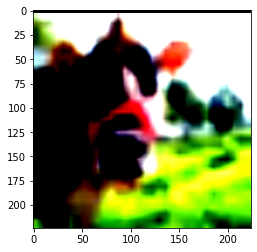

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import time
import os
import torch.backends.cudnn as cudnn

dic = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
        5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
start_time = time.time()
batch_size = 128
learning_rate = 0.1

transform_train = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomCrop(224, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467),
                          std=(0.2471, 0.2436, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467),
                          std=(0.2471, 0.2436, 0.2616))
])

train_dataset = datasets.CIFAR100(root='/home/ljj0512/private/project/data',
                                 train=True,
                                 transform=transform_train,
                                 download=True)

test_dataset = datasets.CIFAR100(root='/home/ljj0512/private/project/data',
                                train=False,
                                transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

print(len(train_dataset))
print(len(test_dataset))

print(train_dataset[0][0].shape)
print(train_dataset[0][0].max())
print(train_dataset[0][0].min())

# import matplotlib.pyplot as plt

# plt.imshow(train_dataset[0][0].permute(1,2,0))
# plt.show()

# size = 1
# x = transforms.RandomCrop(224, padding = size)(train_dataset[0][0])
# print(x.shape)
# plt.imshow(x.permute(1,2,0))
# plt.show()
# for i in range(4):
#     print(x[:,0+i,0+i])
#     print(x[:,-1-i,0+i])
#     print(x[:,0+i,-1-i])
#     print(x[:,-1-i,-1-i])
#     print()

import matplotlib.pyplot as plt

plt.imshow(train_dataset[0][0].permute((1,2,0)))
plt.show()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

if torch.cuda.device_count() > 0:
    print("USE", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    cudnn.benchmark = True
else:
    print("USE ONLY CPU!")

if torch.cuda.is_available():
    model.cuda()


train_loss_graph = []
def train(epoch):
    model.train()
    train_loss = 0
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)
        
        # 모든 gradient를 0으로 set해주는 것은 RNN의 경우를 대비하여 function 자체가 gradient를 accumulate하도록 만들어졌기 때문
        optimizer.zero_grad()
        # forward()한 값을 반환 
        output = model(data)
        loss = criterion(output, target)
        err1,_ = accuracy(output.data, target, topk=(1,5))
        # When you call loss.backward(),
        # all it does is compute gradient of loss w.r.t all the parameters in loss
        # that have requires_grad = True and store them in parameter.grad attribute for every parameter.
        # optimizer.step() updates all the parameters based on parameter.grad
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        # torch.max() : (maximum value, index of maximum value) return. 
        # 1 :  row마다 max계산 (즉, row는 10개의 class를 의미) 
        # 0 : column마다 max 계산 
        total += target.size(0)
        # 가장 높은 값이 나온 클래스들과 target(label)을 비교하여 correct에 더함.
        correct += predicted.eq(target.data).cpu().sum() 
        if not(epoch==0 and batch_idx==0):
          train_loss_graph.append(train_loss/(batch_idx+1))
        if batch_idx % 10 == 0:        
            temp = (1-(err1.item()/100))*100
            print('Epoch: {} | Batch_idx: {} |  Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{}) | top-1 err: ({:.2f}%) | temp: ({:.2f}%)'
                  .format(epoch, batch_idx, train_loss/(batch_idx+1), 100.*correct/total, correct, total, err1.item(), temp))


test_loss_graph = []
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        outputs = model(data)
        loss = criterion(outputs, target)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
    test_loss_graph.append(test_loss/(batch_idx+1))
    print('# TEST : Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
      .format(test_loss/(batch_idx+1), 100.*correct/total, correct, total))

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    print('output', output.shape)
    print('target', target.shape)
  
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

    return res

for epoch in range(0, 1): #165):
    # if epoch < 80:
    #     learning_rate = learning_rate
    # elif epoch < 120:
    #     learning_rate = learning_rate * 0.1
    # else:
    #     learning_rate = learning_rate * 0.01
    # for param_group in optimizer.param_groups:
    #     param_group['learning_rate'] = learning_rate

    train(epoch)
    test()
    print('\n')


import matplotlib.pyplot as plt

plt.plot(train_loss_graph)
plt.title('train loss')
plt.show()

plt.plot(test_loss_graph)
plt.title('test loss')
plt.show()

now = time.gmtime(time.time() - start_time)
print('{} hours {} mins {} secs for training'.format(now.tm_hour, now.tm_min, now.tm_sec))

In [2]:
import torch
import torch.nn as nn

class LinearProjection(nn.Module):

    def __init__(self, patch_vec_size, num_patches, latent_vec_dim, drop_rate):
        super().__init__()
        self.linear_proj = nn.Linear(patch_vec_size, latent_vec_dim)
        self.cls_token = nn.Parameter(torch.randn(1, latent_vec_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, latent_vec_dim))
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.cat([self.cls_token.repeat(batch_size, 1, 1), self.linear_proj(x)], dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        return x

class MultiheadedSelfAttention(nn.Module):
    def __init__(self, latent_vec_dim, num_heads, drop_rate):
        super().__init__()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.num_heads = num_heads
        self.latent_vec_dim = latent_vec_dim
        self.head_dim = int(latent_vec_dim / num_heads)
        self.query = nn.Linear(latent_vec_dim, latent_vec_dim)
        self.key = nn.Linear(latent_vec_dim, latent_vec_dim)
        self.value = nn.Linear(latent_vec_dim, latent_vec_dim)
        self.scale = torch.sqrt(latent_vec_dim*torch.ones(1)).to(device)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        batch_size = x.size(0)
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        q = q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        k = k.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,3,1) # k.t
        v = v.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        attention = torch.softmax(q @ k / self.scale, dim=-1)
        x = self.dropout(attention) @ v
        x = x.permute(0,2,1,3).reshape(batch_size, -1, self.latent_vec_dim)

        return x, attention

class TFencoderLayer(nn.Module):
    def __init__(self, latent_vec_dim, num_heads, mlp_hidden_dim, drop_rate):
        super().__init__()
        self.ln1 = nn.LayerNorm(latent_vec_dim)
        self.ln2 = nn.LayerNorm(latent_vec_dim)
        self.msa = MultiheadedSelfAttention(latent_vec_dim=latent_vec_dim, num_heads=num_heads, drop_rate=drop_rate)
        self.dropout = nn.Dropout(drop_rate)
        self.mlp = nn.Sequential(nn.Linear(latent_vec_dim, mlp_hidden_dim),
                                 nn.GELU(), nn.Dropout(drop_rate),
                                 nn.Linear(mlp_hidden_dim, latent_vec_dim),
                                 nn.Dropout(drop_rate))

    def forward(self, x):
        z = self.ln1(x)
        z, att = self.msa(z)
        z = self.dropout(z)
        x = x + z
        z = self.ln2(x)
        z = self.mlp(z)
        x = x + z

        return x, att

class VisionTransformer(nn.Module):
    def __init__(self, patch_vec_size, num_patches, latent_vec_dim, num_heads, mlp_hidden_dim, drop_rate, num_layers, num_classes):
        super().__init__()
        self.patchembedding = LinearProjection(patch_vec_size=patch_vec_size, num_patches=num_patches,
                                               latent_vec_dim=latent_vec_dim, drop_rate=drop_rate)
        self.transformer = nn.ModuleList([TFencoderLayer(latent_vec_dim=latent_vec_dim, num_heads=num_heads,
                                                         mlp_hidden_dim=mlp_hidden_dim, drop_rate=drop_rate)
                                          for _ in range(num_layers)])

        self.mlp_head = nn.Sequential(nn.LayerNorm(latent_vec_dim), nn.Linear(latent_vec_dim, num_classes))

    def forward(self, x):
        att_list = []
        x = self.patchembedding(x)
        for layer in self.transformer:
            x, att = layer(x)
            att_list.append(att)
        x = self.mlp_head(x[:,0])

        return x, att_list


In [10]:
device = torch.device('cuda:2')
model = VisionTransformer(
    patch_vec_size=4,
    num_patches=
)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda(device)

if torch.cuda.device_count() > 0:
    print("USE", torch.cuda.device_count(), "GPUs!")
    # model = nn.DataParallel(model)
    cudnn.benchmark = True
else:
    print("USE ONLY CPU!")


if torch.cuda.is_available():
    model.cuda(device)
    print('USE index 2 GPU')


train_loss_graph = []
def train(epoch):
    model.train()
    train_loss = 0
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda(device)), Variable(target.cuda(device))
        else:
            data, target = Variable(data), Variable(target)
        
        # 모든 gradient를 0으로 set해주는 것은 RNN의 경우를 대비하여 function 자체가 gradient를 accumulate하도록 만들어졌기 때문
        optimizer.zero_grad()
        # forward()한 값을 반환 
        output = model(data)
        loss = criterion(output, target)
        # When you call loss.backward(),
        # all it does is compute gradient of loss w.r.t all the parameters in loss
        # that have requires_grad = True and store them in parameter.grad attribute for every parameter.
        # optimizer.step() updates all the parameters based on parameter.grad
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        # torch.max() : (maximum value, index of maximum value) return. 
        # 1 :  row마다 max계산 (즉, row는 10개의 class를 의미) 
        # 0 : column마다 max 계산 
        total += target.size(0)
        # 가장 높은 값이 나온 클래스들과 target(label)을 비교하여 correct에 더함.
        correct += predicted.eq(target.data).cpu().sum() 
        if not(epoch==0 and batch_idx==0):
          train_loss_graph.append(train_loss/(batch_idx+1))
        if batch_idx % 10 == 0:        
            print('Epoch: {} | Batch_idx: {} |  Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
                  .format(epoch, batch_idx, train_loss/(batch_idx+1), 100.*correct/total, correct, total))

test_loss_graph = []
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda(device)), Variable(target.cuda(device))
        else:
            data, target = Variable(data), Variable(target)

        outputs = model(data)
        loss = criterion(outputs, target)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
    test_loss_graph.append(test_loss/(batch_idx+1))
    print('# TEST : Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
      .format(test_loss/(batch_idx+1), 100.*correct/total, correct, total))


for epoch in range(0, 5): #165):
    # if epoch < 80:
    #     learning_rate = learning_rate
    # elif epoch < 120:
    #     learning_rate = learning_rate * 0.1
    # else:
    #     learning_rate = learning_rate * 0.01
    # for param_group in optimizer.param_groups:
    #     param_group['learning_rate'] = learning_rate

    train(epoch)
    test()
    print('\n')


import matplotlib.pyplot as plt

plt.plot(train_loss_graph)
plt.title('train loss')
plt.savefig('tarin_loss_graph.jpg')
plt.close()

plt.plot(test_loss_graph)
plt.title('test loss')
plt.savefig('test_loss_graph.jpg')
plt.close()

now = time.gmtime(time.time() - start_time)
print('{} hours {} mins {} secs for training'.format(now.tm_hour, now.tm_min, now.tm_sec))

USE 10 GPUs!
USE index 2 GPU
Epoch: 0 | Batch_idx: 0 |  Loss: (2.4759) | Acc: (13.28%) (17/128)
Epoch: 0 | Batch_idx: 10 |  Loss: (13.9554) | Acc: (12.36%) (174/1408)
Epoch: 0 | Batch_idx: 20 |  Loss: (8.9199) | Acc: (12.24%) (329/2688)
Epoch: 0 | Batch_idx: 30 |  Loss: (6.8371) | Acc: (12.00%) (476/3968)
Epoch: 0 | Batch_idx: 40 |  Loss: (5.7325) | Acc: (11.34%) (595/5248)
Epoch: 0 | Batch_idx: 50 |  Loss: (5.0583) | Acc: (11.18%) (730/6528)
Epoch: 0 | Batch_idx: 60 |  Loss: (4.6067) | Acc: (11.18%) (873/7808)
Epoch: 0 | Batch_idx: 70 |  Loss: (4.2815) | Acc: (11.00%) (1000/9088)
Epoch: 0 | Batch_idx: 80 |  Loss: (4.0381) | Acc: (10.91%) (1131/10368)
Epoch: 0 | Batch_idx: 90 |  Loss: (3.8469) | Acc: (10.83%) (1261/11648)
Epoch: 0 | Batch_idx: 100 |  Loss: (3.6926) | Acc: (10.88%) (1406/12928)
Epoch: 0 | Batch_idx: 110 |  Loss: (3.5657) | Acc: (10.92%) (1551/14208)
Epoch: 0 | Batch_idx: 120 |  Loss: (3.4597) | Acc: (10.97%) (1699/15488)
Epoch: 0 | Batch_idx: 130 |  Loss: (3.3700) | Acc